In [3]:
using local_POD_overlap.module_2D

using LinearAlgebra
using Plots
using LaTeXStrings
using ProgressBars

import LinearAlgebra.eigvals 
using Statistics
using Random
using Distributions
using SparseArrays

In [445]:
function overlap_shifter(data,overlap_MP;index = 3,forward = true)


    shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))

    if forward
        shifted_x = circshift( data,(shift_x,0))
        shifted_y = circshift( data,(0,shift_y))
        shifted_x_y = circshift( data,(shift_x,shift_y))
    else
        shifted_x = circshift( data,(-shift_x,0))
        shifted_y = circshift( data,(0,-shift_y))
        shifted_x_y = circshift( data,(-shift_x,-shift_y))


    end
    
    indexes = collect(1:size(data)[index])
    shifted_indexes_x = indexes .+ size(data)[index]
    shifted_indexes_y = indexes .+ 2*size(data)[index]
    shifted_indexes_x_y = indexes .+ 3*size(data)[index]

    indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    
    modes = cat(data,shifted_x,shifted_y,shifted_x_y,dims = index)
    
    return modes[[(:) for i in 1:index-1]...,indexes,[(:) for i in 1:(length(size(modes))-index)]...]
end

function carry_out_local_SVD_overlap_2D_periodic_only(input,MP)

    UPC = MP.fine_mesh.UPC
    dims = MP.fine_mesh.dims
    
    overlap_fine_mesh = MP.fine_mesh
    overlap_coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh, 2 .* MP.J)
    overlap_MP = gen_mesh_pair(overlap_fine_mesh,overlap_coarse_mesh)
    
    kernel_x= collect(LinRange(-1,1,overlap_MP.J[1]+1))
    kernel_y = collect(LinRange(-1,1,overlap_MP.J[2]+1))

    kernel_mesh = gen_mesh(kernel_x,kernel_y,UPC = UPC,use_GPU = false)
    kernel = kernel_mesh.eval_function(mollifier_bump_kernel)

    input =  overlap_shifter(input,overlap_MP,index = 4)
    reshaped_input = kernel .* reshape_for_local_SVD(input,overlap_MP,subtract_average = false)
    

    vector_input = reshape(reshaped_input,(prod(size(reshaped_input)[1:end-1]),size(reshaped_input)[end]))

    SVD = svd(vector_input)

    return  reshape(SVD.U,(overlap_MP.J...,UPC,Int(size(SVD.U)[end]))),SVD.S,overlap_MP
end




    


function bilinear_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)

    
    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    

    

    

    f1 = (x1 ) .* (y1)
    f2 = (1 .- x2 ) .* ( y2 )
    f3 = (x3 ) .* (1 .- y3  )
    f4 = (1 .- x4) .* (1 .- y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end


function mollifier_bump_kernel(x)

    m1 = (x[1] .< 0) .* (x[2] .< 0)
    
    m2 = (x[1] .>= 0) .* (x[2] .< 0)
    m3 = (x[1] .< 0) .* (x[2] .>= 0) 
    m4 = (x[1] .>= 0) .* (x[2] .>= 0)


    x1,y1 = x[1] .+ 1, x[2] .+ 1
    x2,y2 = x[1] , x[2] .+ 1
    x3,y3 = x[1] .+ 1, x[2] 
    x4,y4 = x[1] , x[2] 

    delta = 1e-10
    ## circumvent the NaN at x = 0
    x1,y1 = max.(x1,delta), max.(y1,delta)
    x2,y2 = max.(x2,delta), max.(y2,delta)
    x3,y3 = max.(x3,delta), max.(y3,delta)
    x4,y4 = max.(x4,delta), max.(y4,delta)

    
    eta(x) = exp.(-(x)/(x*(1-x)))

    eta_tilde(x) = eta(x)/(eta(x)+eta(1-x))
    a(x) = eta_tilde(x)
    b(x) = 1 -a(x)
    
    f1 = b.(x1) .* b.(y1)
    f2 = a.(x2) .* b.(y2)
    f3 = b.(x3) .* a.(y3)
    f4 = a.(x4) .* a.(y4)


    return m1 .* f1 .+ m2 .* f2 .+ m3 .* f3 .+ m4 .* f4
    #return m3
end




struct overlap_projection_operators_struct
    Phi_T
    Phi
    S_inv
end

function generate_ROM_operator(input_dimension,proj_FOM_rhs)

    dummy_vec = zeros(input_dimension)

    
    
    ROM_operator = zeros((input_dimension...,input_dimension...))

    for i in 1:input_dimension[1]
        test_vec = copy(dummy_vec)
        test_vec[i] += 1

        
        result = proj_FOM_rhs(test_vec)
        #output = reshape(,shape_2)

        ROM_operator[:,i] .+= result

    end
    
    return sparsify_matrix(ROM_operator)
end

function sparsify_matrix(A,tolerance = 1e-10)
    B = spzeros(size(A))
    for i in 1:size(A)[1]
        for j in 1:size(A)[2]
            if abs(A[i,j]) >= tolerance
                B[i,j] += A[i,j]
            end
        end
    end
    return B
end

function generate_S(overlap_MP,Phi_T,Phi)

    dummy_input = zeros(overlap_MP.fine_mesh.N...,1,1)
    dummy_vec = 0 * Phi_T(dummy_input)

    shape_1 = size(dummy_vec)
    shape_2 = (prod(shape_1),)

    dummy_vec = reshape(dummy_vec,shape_2)
    
    
    S = zeros((shape_2[1],shape_2[1]))

    for i in 1:shape_2[1]
        test_vec = copy(dummy_vec)
        test_vec[i] += 1

        test_vec = reshape(test_vec,shape_1)

        corresponding_state = Phi(test_vec)
        corresponding_coefficients = Phi_T(corresponding_state)
        overlap = reshape(corresponding_coefficients,shape_2)
        
        #output = reshape(,shape_2)

        S[:,i] .+= overlap

    end
    
    return sparsify_matrix(S)
end


function gen_projection_operators_overlap_2D_periodic_only(overlap_modes,overlap_MP)
    PO = gen_projection_operators(overlap_modes,overlap_MP)
    
    function Phi_T(input,PO = PO,overlap_MP = overlap_MP)
        


        dims = overlap_MP.fine_mesh.dims
        shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))

        output_1 = PO.Phi_T(input)
        output_2 = PO.Phi_T(circshift(input,(shift_x,0)))
        output_3 = PO.Phi_T(circshift(input,(0,shift_y)))
        output_4 = PO.Phi_T(circshift(input,(shift_x,shift_y)))

        indexes = collect(1:size(output_1)[dims+1])
        shifted_indexes_x = indexes .+ size(output_1)[dims+1]
        shifted_indexes_y = indexes .+ 2*size(output_1)[dims+1]
        shifted_indexes_x_y = indexes .+ 3*size(output_1)[dims+1]
    
        indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    
        
        output = cat(output_1,output_2,output_3,output_4,dims = dims + 1)

        return output[:,:,indexes,:]
        return input
    end

    function Phi(input,PO = PO,overlap_MP = overlap_MP)

        dims = overlap_MP.fine_mesh.dims
        
        shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))
        
        number_of_modes = size(input)[dims+1]
        unique_modes = Int(round(number_of_modes/4))
        index_1 = 4 * collect(0:unique_modes-1) .+ 1 
        index_2 = index_1 .+ 1
        index_3 = index_1 .+ 2
        index_4 = index_1 .+ 3


        output_1 = PO.Phi(input[:,:,index_1,:]) 
        output_2 = circshift(PO.Phi(input[:,:,index_2,:]),(-shift_x,0) )
        output_3 = circshift(PO.Phi(input[:,:,index_3,:]),(0,-shift_y)) 
        output_4 = circshift(PO.Phi(input[:,:,index_4,:]),(-shift_x,-shift_y)) 
        
       
        return output_1 .+ output_2 .+ output_3 .+ output_4
    end

    S = generate_S(overlap_MP,Phi_T,Phi)
    inv_S = inv(Matrix(S))
    
    function S_inv(input,S = S, inv_S = inv_S)

        shape_1 = size(input)
        shape_2 = (prod(shape_1[1:end-1]),shape_1[end])

        reshaped_input = reshape(input,shape_2)
        solved = inv_S * reshaped_input
        #solved = solve(S,reshaped_input)
        output = reshape(solved,shape_1)
        
        
        return output


    end 

    
    return overlap_projection_operators_struct(Phi_T,Phi,S_inv)
end


gen_projection_operators_overlap_2D_periodic_only (generic function with 1 method)

In [446]:
N = (128,128)
UPC = 1       
use_GPU = false

x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = use_GPU)
velocity_mesh = gen_mesh(x,y,UPC = fine_mesh.dims,use_GPU = use_GPU)
setup = gen_setup(velocity_mesh)
0

0

In [447]:
u_f(x) = 2*pi* sin.(x[2]) .* cos.(x[1])
v_f(x) = -2*pi* sin.(x[1]) .* cos.(x[2])

u = velocity_mesh.eval_function(u_f)
v = velocity_mesh.eval_function(v_f)

V = cat(u,v,dims = 3)[:,:,:,:]
V = project_divergence(V,setup)
w0 = setup.O.w(V)
setup.O.M(V)
0

0

In [772]:
#q0_f(x) = exp.(-0.2*(x[1].^2 .+ x[2].^2))
q0_f(x) = sin.(x[1])
#q0_f(x) = sin.(5* x[1] ) +  cos.(4*x[2]) + 0.5 *cos.(7* x[1] )
q0 = fine_mesh.eval_function(q0_f)
#q0 =gen_random_field(fine_mesh.N,10, samples = (1,1))

128×128×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.0245412  -0.0245412  -0.0245412  …  -0.0245412  -0.0245412  -0.0245412
 -0.0735646  -0.0735646  -0.0735646     -0.0735646  -0.0735646  -0.0735646
 -0.122411   -0.122411   -0.122411      -0.122411   -0.122411   -0.122411
 -0.170962   -0.170962   -0.170962      -0.170962   -0.170962   -0.170962
 -0.219101   -0.219101   -0.219101      -0.219101   -0.219101   -0.219101
 -0.266713   -0.266713   -0.266713   …  -0.266713   -0.266713   -0.266713
 -0.313682   -0.313682   -0.313682      -0.313682   -0.313682   -0.313682
 -0.359895   -0.359895   -0.359895      -0.359895   -0.359895   -0.359895
 -0.405241   -0.405241   -0.405241      -0.405241   -0.405241   -0.405241
 -0.449611   -0.449611   -0.449611      -0.449611   -0.449611   -0.449611
 -0.492898   -0.492898   -0.492898   …  -0.492898   -0.492898   -0.492898
 -0.534998   -0.534998   -0.534998      -0.534998   -0.534998   -0.534998
 -0.575808   -0.575808   -0.575808      -0.575808   -0.575808   

In [979]:
viscosity = 0.1
rhs = gen_rhs_advection_equation(setup,V = V,viscosity = viscosity)
t,  res = simulate(q0,fine_mesh,0.005,0,0.5,rhs,save_every = 10)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


([0.049999999999999996;;;;; 0.10000000000000002;;;;; 0.15000000000000005;;;;; 0.2000000000000001;;;;; 0.2500000000000001;;;;; 0.30000000000000016;;;;; 0.3500000000000002;;;;; 0.40000000000000024;;;;; 0.4500000000000003;;;;; 0.5000000000000003], [-0.011401668838731713 0.0035674694699899773 … -0.04137493859951015 -0.02639559616999953; -0.05789630370845157 -0.0429888545838087 … -0.08771627150345973 -0.07281850467544662; … ; 0.08145798183599247 0.09635215645401808 … 0.0515751151296038 0.06651923978664363; 0.03507624279961553 0.05004091088572459 … 0.0050819510895496935 0.02007679820648336;;;;; 0.0037274021487275592 0.031952993211123486 … -0.05280414207005814 -0.024554431676531867; -0.03588483761004552 -0.007733649276808084 … -0.0921883258718031 -0.06406574690186724; … ; 0.08265581461633936 0.11073980355381102 … 0.026249815873506985 0.05446315094919792; 0.04323574014230883 0.07143881977386095 … -0.013329975853017335 0.014950023691329504;;;;; 0.019349432906095167 0.05793174034056379 … -0.0579

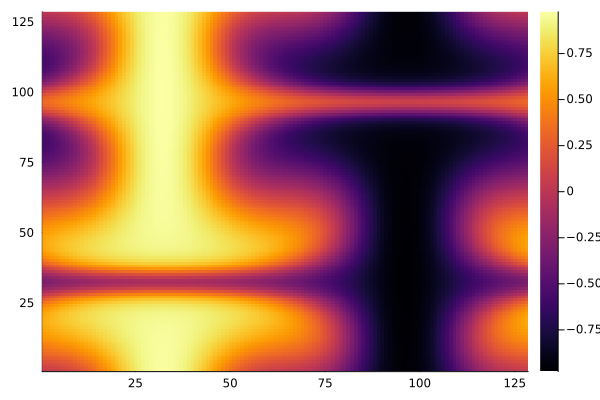

In [941]:
heatmap(res[:,:,1,1,end])

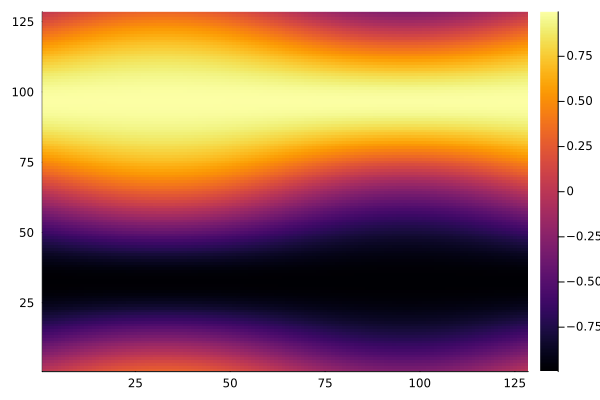

In [942]:
heatmap(res[:,:,1,1,1])

In [922]:
J = (16,16) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0

data = res[:,:,:,1,:]


128×128×1×10 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.0114017   0.00356747   0.0184725   0.0332744  …  -0.0413749   -0.0263956
 -0.0578963  -0.0429889   -0.0281354  -0.0133749     -0.0877163   -0.0728185
 -0.104327   -0.0895475   -0.0748113  -0.0601578     -0.133863    -0.119112
 -0.150614   -0.136026    -0.121473   -0.106991      -0.179736    -0.165197
 -0.196673   -0.182341    -0.168034   -0.153787      -0.225255    -0.21099
 -0.242419   -0.228405    -0.214406   -0.200458   …  -0.27034     -0.256409
 -0.287765   -0.274129    -0.260498   -0.246908      -0.314909    -0.30137
 -0.332622   -0.31942     -0.306214   -0.29304       -0.358877    -0.345786
 -0.376897   -0.364182    -0.351455   -0.338751      -0.402159    -0.389567
 -0.420493   -0.408315    -0.396118   -0.383935      -0.444667    -0.432621
 -0.463313   -0.451716    -0.440094   -0.428479   …  -0.486311    -0.474855
 -0.505253   -0.494278    -0.483273   -0.472268      -0.527       -0.51617
 -0.54621    -0.535892    -0.525539   -0.5

In [923]:
modes,S = carry_out_local_SVD(data,MP)
overlap_modes,overlap_S,overlap_MP = carry_out_local_SVD_overlap_2D_periodic_only(data,MP)
0

0

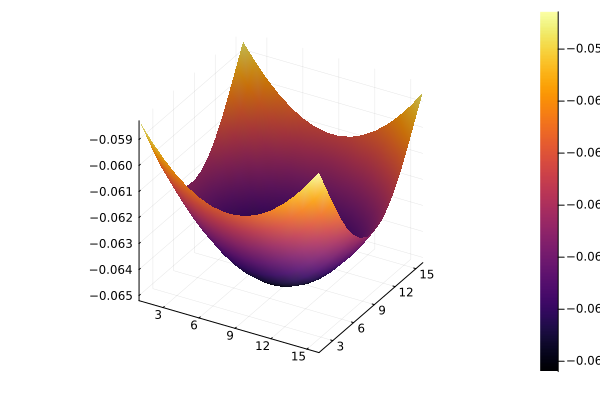

In [924]:
surface(modes[:,:,1,1])

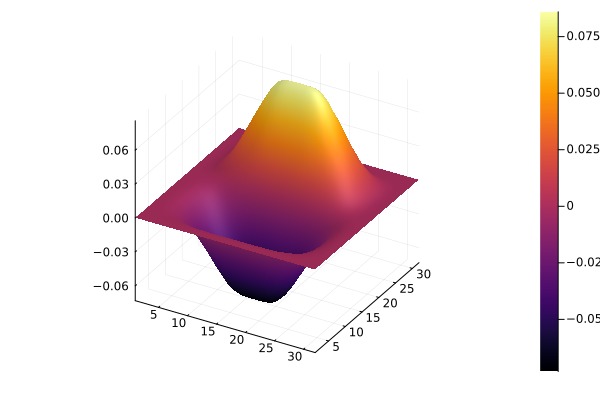

In [925]:
surface(overlap_modes[:,:,1,2])

In [926]:
function compute_L2(a;average = true)
    if average
        return mean(sqrt.(sum(a.^2,dims = [1,2])))
    else
        return sqrt.(sum(a.^2,dims = [1,2]))
    end
end

rs = 1:10
local_errors = []
overlap_errors = []

for r in rs

    local_PO = gen_projection_operators(modes[:,:,:,1:r],MP)
    overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:r],overlap_MP)
    #S = generate_S(overlap_MP,overlap_PO.Phi_T,overlap_PO.Phi)
    
    overlap_a = overlap_PO.Phi_T(data)
    solved = overlap_PO.S_inv(overlap_a)
    overlap_u_r = overlap_PO.Phi(solved)

    local_a = local_PO.Phi_T(data)
    local_u_r = local_PO.Phi(local_a)

    local_error = compute_L2(data - local_u_r)
    overlap_error = compute_L2(data - overlap_u_r)

    push!(local_errors,local_error)
    push!(overlap_errors,overlap_error)

end

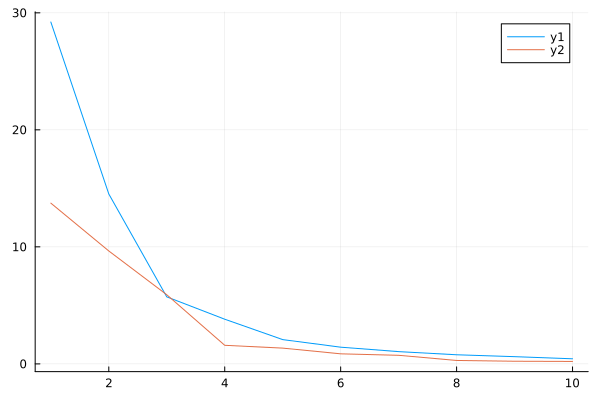

In [927]:
plot(local_errors)
plot!(overlap_errors)

In [956]:
r = 10

local_PO = gen_projection_operators(modes[:,:,:,1:r],MP)
overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:r],overlap_MP)
0

0

In [957]:
function proj_FOM(a,PO,rhs,fine_mesh ; overlap = false)
    new_shape = size(PO.Phi_T(fine_mesh.omega))
    num_inputs = Int(round(prod(size(a))/prod(new_shape)))
    
    old_shape = prod(size(a))
    new_shape = (new_shape[1:end-1]...,num_inputs)

    q_r = PO.Phi(reshape(a,new_shape))
    rhs_q = rhs(q_r,fine_mesh,0)
    rhs_a = PO.Phi_T(rhs_q)
    
    if overlap
        rhs_a = PO.S_inv(rhs_a)
    end
    
    rhs_a = reshape(rhs_a,old_shape)
    return rhs_a
end



proj_FOM (generic function with 5 methods)

In [958]:
local_proj_FOM(a,PO = local_PO,rhs = rhs,fine_mesh = fine_mesh,overlap = false) = proj_FOM(a,PO,rhs,fine_mesh, overlap = overlap)
overlap_proj_FOM(a,PO = overlap_PO,rhs = rhs,fine_mesh = fine_mesh,overlap = true) = proj_FOM(a,PO,rhs,fine_mesh, overlap = overlap)


overlap_proj_FOM (generic function with 5 methods)

In [959]:
local_a0 = local_PO.Phi_T(q0)[1:end]
overlap_a0 = overlap_PO.S_inv(overlap_PO.Phi_T(q0))[1:end]

local_A = generate_ROM_operator(size(local_a0),local_proj_FOM)
overlap_A = generate_ROM_operator(size(overlap_a0),overlap_proj_FOM)

local_rhs(a,mesh,t;A = local_A,other_arguments = 0) = A * a
overlap_rhs(a,mesh,t;A = overlap_A,other_arguments = 0) = A * a



overlap_rhs (generic function with 2 methods)

In [973]:
t,  local_res = simulate(local_a0,coarse_mesh,0.025,0,10,local_rhs,save_every = 2)
t,  overlap_res = simulate(overlap_a0,coarse_mesh,0.025,0,10,overlap_rhs,save_every = 2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


([0.05 0.1 … 9.950000000000074 10.000000000000075; 0.05 0.1 … 9.950000000000074 10.000000000000075; … ; 0.05 0.1 … 9.950000000000074 10.000000000000075; 0.05 0.1 … 9.950000000000074 10.000000000000075], [7.209587449475403 4.855824556238141 … -0.008652163685381811 -0.008578182835746337; 7.180375993325976 4.794942433245783 … 0.02549629646529923 0.025181188436632116; … ; 0.0014338524501488134 0.0020514901978921233 … 3.206570604659826e-5 6.134866793421465e-5; -0.004829369435391162 -0.006318567224826059 … -3.549525218138306e-5 -3.5928842561455385e-5])

In [974]:
local_q_r = local_PO.Phi(reshape(local_res,(coarse_mesh.N...,r,size(local_res)[end])))

overlap_shape = ((Int.(round.(coarse_mesh.N) ./ 2))...,4*r,size(overlap_res)[end]) 
overlap_q_r = overlap_PO.Phi(reshape(overlap_res,overlap_shape))

128×128×1×200 Array{Float32, 4}:
[:, :, 1, 1] =
 -0.0118901   0.00294926   0.0177121  …  -0.0563732   -0.0416313  -0.0267781
 -0.0592884  -0.0444079   -0.0295409     -0.1036      -0.0889783  -0.0741728
 -0.10665    -0.0917474   -0.0768007     -0.150745    -0.136257   -0.121514
 -0.153252   -0.138374    -0.123408      -0.197051    -0.182708   -0.168058
 -0.198766   -0.18399     -0.169106      -0.242144    -0.22796    -0.21345
 -0.243633   -0.229064    -0.214389   …  -0.286397    -0.272411   -0.258109
 -0.288281   -0.274045    -0.259726      -0.330161    -0.31644    -0.302439
 -0.33274    -0.318982    -0.305178      -0.373397    -0.360035   -0.34645
 -0.376737   -0.36361     -0.350488      -0.415783    -0.402894   -0.389855
 -0.419904   -0.407563    -0.395281      -0.456933    -0.444639   -0.432285
 -0.461998   -0.450575    -0.439264   …  -0.496632    -0.485052   -0.47351
 -0.503098   -0.492674    -0.482403      -0.535056    -0.52429    -0.513654
 -0.543621   -0.534189    -0.52493       

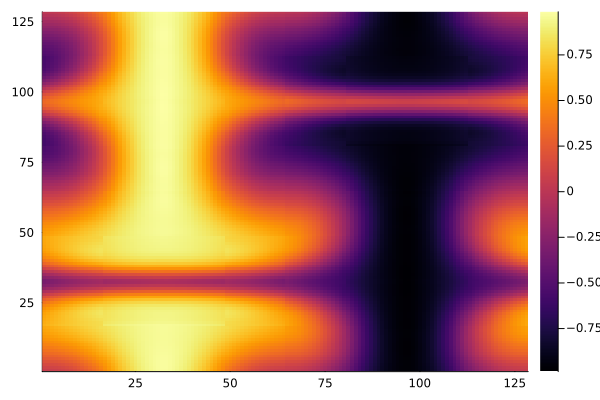

In [975]:
heatmap(local_PO.Phi(local_PO.Phi_T(data))[:,:,1,end])

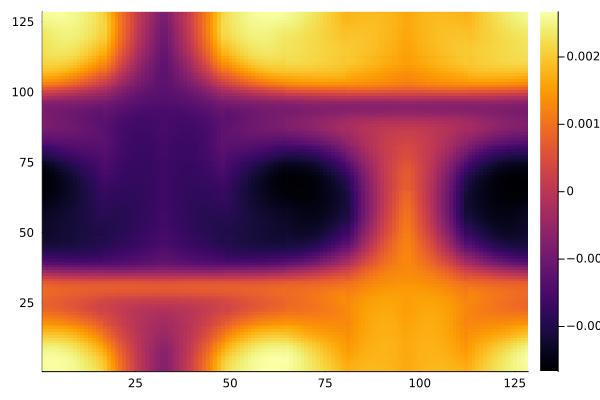

In [976]:
heatmap(local_q_r[:,:,1,end])

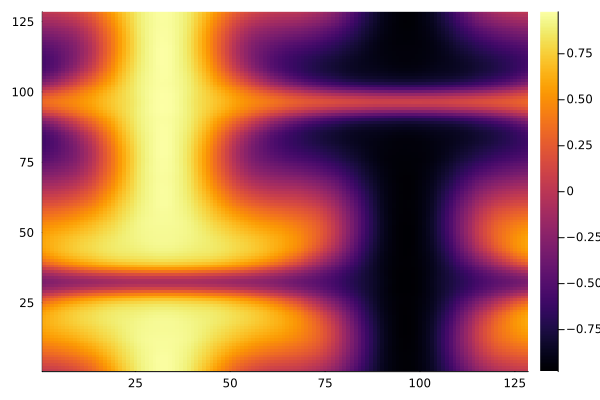

In [977]:
heatmap(overlap_PO.Phi(overlap_PO.S_inv(overlap_PO.Phi_T(data)))[:,:,1,end])

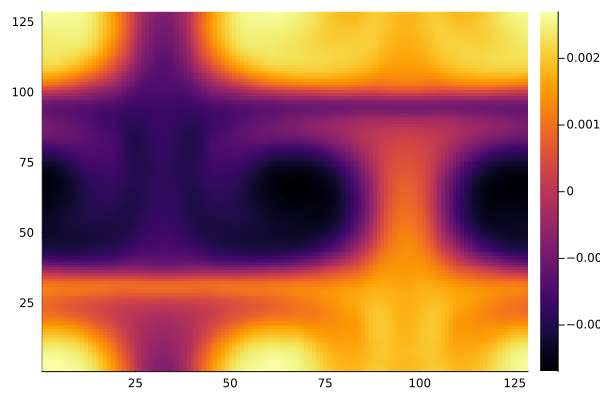

In [978]:
heatmap(overlap_q_r[:,:,1,end])

### 

# Code plan

## - Code energy-preserving discretization
## - Randomly generate turbulent velocity fields
## - Do a pressure projection on the velocity fields
## - Run the simulation 
## - Implement local POD with overlap
## - Implement projection
## - Test POD approaches

In [1]:
N = (512,512)
UPC = 1       


x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

fine_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)

# number of unknowns per cell

J = (64,64) # compression in each direction
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J)
MP = gen_mesh_pair(fine_mesh,coarse_mesh)
0



LoadError: UndefVarError: `gen_mesh` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [3]:
eta(x) = exp.(-(x)/(x*(1-x)))

eta (generic function with 1 method)

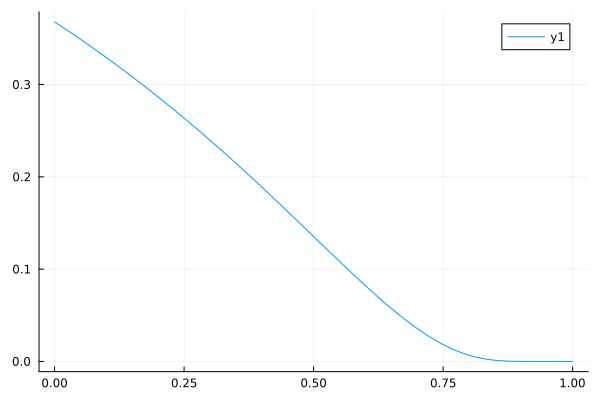

In [4]:
plot(collect(LinRange(0,1,3000)),eta.( collect(LinRange(0,1,3000))))

mollifier_bump_kernel (generic function with 1 method)

In [6]:
J =  4 .* MP.J
x= collect(LinRange(-1,1,J[1]+1))
y = collect(LinRange(-1,1,J[2]+1))

full_filter_mesh = gen_mesh(x,y,UPC = UPC,use_GPU = false)
full_filter_mesh.x
0

0

In [7]:
test = full_filter_mesh.eval_function(mollifier_bump_kernel)

100×100×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0          0.0          0.0          …  0.0          0.0
 0.0  8.69719e-29  5.50747e-23  1.70791e-20     8.72837e-29  9.52626e-58
 0.0  5.50747e-23  3.48759e-17  1.08153e-14     5.52721e-23  6.03248e-52
 0.0  1.70791e-20  1.08153e-14  3.35391e-12     1.71403e-20  1.87072e-49
 0.0  4.18237e-19  2.64847e-13  8.21313e-11     4.19736e-19  4.58106e-48
 0.0  3.23131e-18  2.04622e-12  6.34548e-10  …  3.24289e-18  3.53934e-47
 0.0  1.3413e-17   8.49375e-12  2.63398e-9      1.34611e-17  1.46916e-46
 0.0  3.833e-17    2.42724e-11  7.52706e-9      3.84674e-17  4.19839e-46
 0.0  8.59491e-17  5.4427e-11   1.68783e-8      8.62572e-17  9.41423e-46
 0.0  1.63092e-16  1.03278e-10  3.20272e-8      1.63677e-16  1.78639e-45
 0.0  2.74404e-16  1.73765e-10  5.3886e-8    …  2.75387e-16  3.00562e-45
 0.0  4.22045e-16  2.67259e-10  8.28791e-8      4.23558e-16  4.62277e-45
 0.0  6.05894e-16  3.83681e-10  1.18982e-7      6.08066e-16  6.63652e-45
 ⋮           

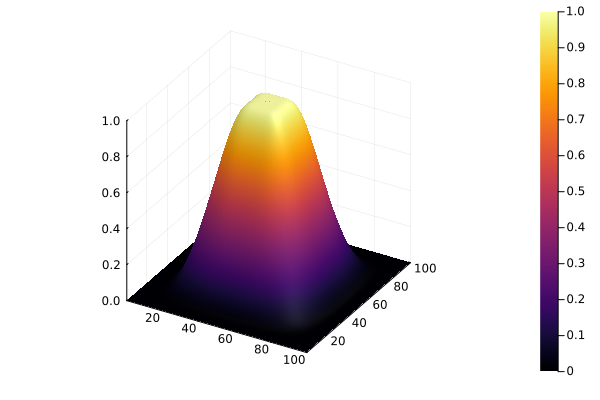

In [8]:
surface(test[:,:,1,1])

In [9]:
dummy_data = gen_random_field(fine_mesh.N,10, samples = (1,20))

200×200×1×20 Array{Float64, 4}:
[:, :, 1, 1] =
 -0.54877    -0.360675   -0.197671   …  -1.14858    -0.955223    -0.751036
 -0.670812   -0.472013   -0.295626      -1.28776    -1.09094     -0.881141
 -0.761498   -0.556206   -0.370381      -1.3825     -1.18652     -0.975519
 -0.812766   -0.60555    -0.414698      -1.42433    -1.23353     -1.02586
 -0.819113   -0.614592   -0.423278      -1.4082     -1.22667     -1.02672
 -0.778153   -0.580697   -0.393332   …  -1.33294    -1.1643      -0.976054
 -0.690968   -0.504424   -0.324975      -1.20153    -1.04872     -0.87552
 -0.562214   -0.389681   -0.22142       -1.02102    -0.886197    -0.730564
 -0.399959   -0.243618   -0.0889291     -0.802179   -0.68662     -0.550181
 -0.215275   -0.0762888   0.0634618     -0.558917   -0.463013    -0.34644
 -0.0215913   0.0999313   0.224454   …  -0.307418   -0.230738    -0.133775
  0.166147    0.271116    0.381185      -0.0651426  -0.00653275   0.071924
  0.332461    0.422707    0.520084       0.15029     0.19

carry_out_local_SVD_overlap_2D_periodic_only (generic function with 1 method)

In [11]:

modes,S = carry_out_local_SVD(dummy_data,MP)
overlap_modes,overlap_S,overlap_MP = carry_out_local_SVD_overlap_2D_periodic_only(dummy_data,MP)

([-3.171028979887687e-17 1.3954098843037635e-19 … 0.0 0.0; -1.3118895889518286e-16 -2.469707303597361e-17 … -9.495888909636959e-17 -2.787536778809189e-31; … ; -2.0932931373794427e-20 -5.859501185018598e-17 … -5.4919014985903646e-17 -1.8828761798483804e-31; -6.423577827599351e-20 -1.3899570700760188e-23 … -1.4375552189340061e-31 -4.847165675694789e-46;;;; 5.614954089950052e-17 4.376838437219661e-20 … 0.0 0.0; -1.3881461101997786e-17 -6.016693382377734e-18 … -1.1044191752291333e-16 -3.1608092898387705e-31; … ; -6.914715564227136e-20 8.621654947853171e-17 … -4.5601015791029365e-18 -6.856391031016286e-32; 1.5387216972725056e-19 9.05814104557181e-25 … -6.864371516646378e-32 -4.602944745822581e-46;;;; 1.6028933106364286e-17 -4.270003066240235e-20 … 0.0 0.0; -7.579701969563183e-17 -6.006110939742911e-18 … -1.518912649926808e-16 -4.237474095947643e-31; … ; -8.517601790049995e-20 -2.068182184847427e-18 … -5.290914058080335e-17 -1.801400153091803e-31; -5.3085485249647394e-20 -1.750515316019707e-

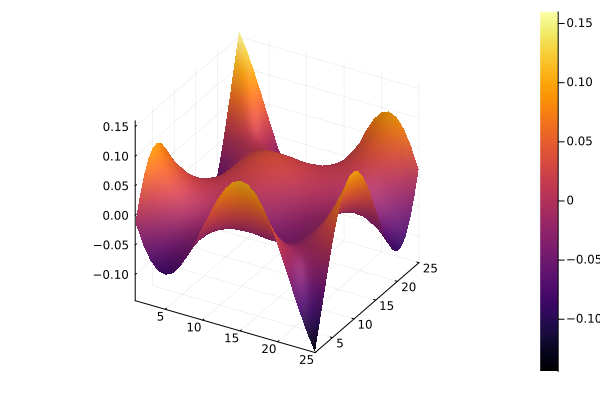

In [12]:
surface(modes[:,:,1,15])

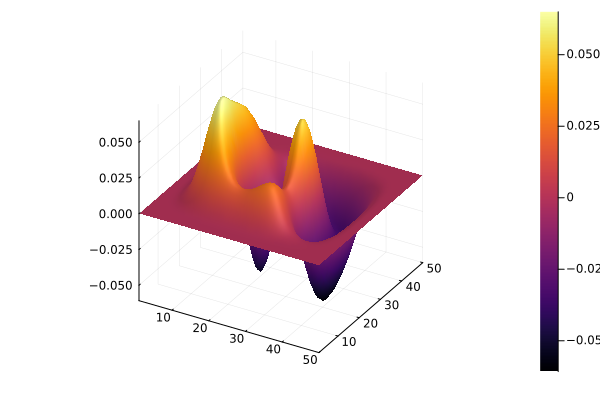

In [13]:
surface(overlap_modes[:,:,1,10])

In [14]:
function local_to_global_modes_overlap_2D_periodic_only(overlap_modes,overlap_MP)
    overlap_global_modes = local_to_global_modes(overlap_modes,overlap_MP)

    shift_x, shift_y = Int.(round.(1/2 .* overlap_MP.J))
    
    shifted_x = circshift( overlap_global_modes,(shift_x,0))
    shifted_y = circshift( overlap_global_modes,(0,shift_y))
    
    shifted_x_y = circshift( overlap_global_modes,(shift_x,shift_y))
    dims = overlap_MP.fine_mesh.dims
    modes = cat(overlap_global_modes,shifted_x,shifted_y,shifted_x_y,dims = dims +2)
    indexes = collect(1:size(overlap_global_modes)[end])
    shifted_indexes_x = indexes .+ size(overlap_global_modes)[end]
    shifted_indexes_y = indexes .+ 2*size(overlap_global_modes)[end]
    shifted_indexes_x_y = indexes .+ 3*size(overlap_global_modes)[end]

    indexes = cat(indexes,shifted_indexes_x,shifted_indexes_y,shifted_indexes_x_y,dims = 2)'[1:end]
    #return modes[:,:,:,indexes]
    return overlap_shifter(overlap_global_modes,overlap_MP,index = 4)
end


local_to_global_modes_overlap_2D_periodic_only (generic function with 1 method)

In [15]:
heatmap(overlap_global_modes[:,:,1,1])

LoadError: UndefVarError: `overlap_global_modes` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
heatmap(global_modes[:,:,1,1])

LoadError: UndefVarError: `global_modes` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# Generating POD operators

In [17]:


r = 10

PO = gen_projection_operators(modes[:,:,:,1:r],MP)
overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:r],overlap_MP)
S = generate_S(overlap_MP,overlap_PO.Phi_T,overlap_PO.Phi)

640×640 SparseMatrixCSC{Float64, Int64} with 57600 stored entries:
⎡⣵⣿⣿⣿⣷⣿⣿⣿⣷⣷⣿⣿⣷⣷⣿⣿⣷⣷⣿⣿⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢕⢕⣿⣿⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⢽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⣿⣿⢕⢕⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣷⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎣⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⢿⣿⣿⢿⢿⣿⣿⢿⢿⣿⣿⢿⢿⣿⣿⣿⢿⣿⣿⣿⢟⎦

In [18]:
r = 10

function compute_L2(a;average = true)
    if average
        return mean(sqrt.(sum(a.^2,dims = [1,2])))
    else
        return sqrt.(sum(a.^2,dims = [1,2]))
    end
end

rs = 1:2
local_errors = []
overlap_errors = []

for r in rs

    local_PO = gen_projection_operators(modes[:,:,:,1:r],MP)
    overlap_PO = gen_projection_operators_overlap_2D_periodic_only(overlap_modes[:,:,:,1:r],overlap_MP)
    #S = generate_S(overlap_MP,overlap_PO.Phi_T,overlap_PO.Phi)
    
    overlap_a = overlap_PO.Phi_T(dummy_data)
    solved = overlap_PO.S_inv(overlap_a)
    overlap_u_r = overlap_PO.Phi(solved)

    local_a = local_PO.Phi_T(dummy_data)
    local_u_r = local_PO.Phi(local_a)

    local_error = compute_L2(dummy_data - local_u_r)
    overlap_error = compute_L2(dummy_data - overlap_u_r)

    push!(local_errors,local_error)
    push!(overlap_errors,overlap_error)

end

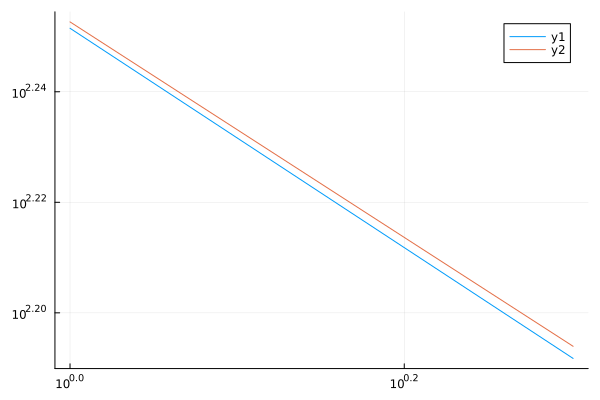

In [19]:
plot(local_errors,yscale = :log10, xscale = :log10)
plot!(overlap_errors)

In [20]:
heatmap(overlap_u_r[:,:,1,1])

LoadError: UndefVarError: `overlap_u_r` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

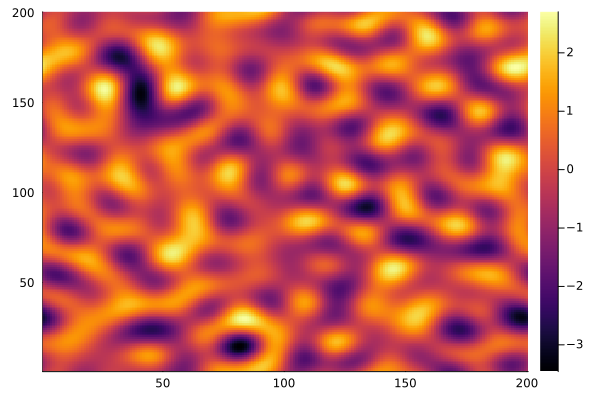

In [21]:
heatmap(dummy_data[:,:,1,1])

In [22]:

x= collect(LinRange(-pi,pi,N[1]+1))
y = collect(LinRange(-pi,pi,N[2]+1))

velocity_mesh = gen_mesh(x,y,UPC = 2,use_GPU = false)

setup = gen_setup(velocity_mesh)

setup.O_adv.A.weight

3×3×1×2 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0
 0.0  0.5  0.0
 0.0  0.5  0.0

[:, :, 1, 2] =
 0.0  0.0  0.0
 0.0  0.5  0.5
 0.0  0.0  0.0

In [23]:
u_f(x) = 2*pi* sin.(x[2]) .* cos.(x[1])
v_f(x) = -2*pi* sin.(x[1]) .* cos.(x[2])

u = velocity_mesh.eval_function(u_f)
v = velocity_mesh.eval_function(v_f)

V = cat(u,v,dims = 3)[:,:,:,:]
V = project_divergence(V,setup)
w0 = setup.O.w(V)
setup.O.M(V)

198×198×1×1 Array{Float32, 4}:
[:, :, 1, 1] =
 -1.72604f-6   1.58043f-6  -1.56285f-6  …  -1.70077f-7  -7.28056f-8
  1.73619f-6  -2.35572f-6  -1.79312f-7      6.34794f-7   1.29205f-6
  1.83837f-7  -1.93089f-6   2.45737f-6     -3.22174f-8  -5.15803f-7
  1.55148f-6   1.20238f-6  -2.04653f-6     -1.96666f-6   4.95601f-7
 -3.52339f-6  -4.2862f-6    3.45794f-6      6.26999f-7   2.573f-6
  2.31058f-7   6.37164f-6  -3.96479f-6  …   1.9491f-6   -1.27616f-8
 -4.4793f-6    5.32319f-7   5.80286f-6      5.56545f-6  -3.61527f-6
  2.89616f-6  -1.23338f-6  -1.14383f-7     -2.32573f-6   8.72024f-7
  7.85215f-7   6.06415f-6  -1.5084f-6       2.29836f-6  -5.34019f-7
  9.25495f-6  -3.28435f-6   2.41291f-6      5.13225f-6  -6.8398f-6
 -5.33554f-6   5.60371f-6  -2.97829f-6  …  -9.03138f-7   1.61881f-6
 -8.32525f-6   2.59993f-6   1.67977f-5      3.57427f-6  -1.45177f-6
  7.86111f-6   2.8687f-6   -7.01819f-6      3.1307f-6   -8.8713f-7
  ⋮                                     ⋱               
 -6.02459f-6  -1.

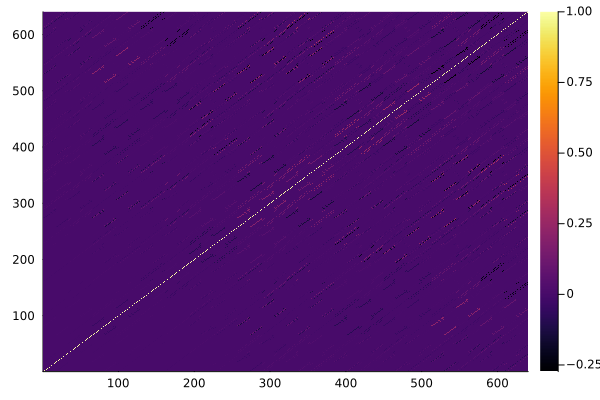

In [24]:
heatmap(S)

In [25]:
q = dummy_data[:,:,1:1,10:10]


A_q = setup.O_adv.A(padding(q,(1,1)))

V_A_q = V .* A_q

C_q = setup.O_adv.C(padding(V_A_q,(1,1)))

D_q = setup.O_adv.D(padding(q,(1,1)))

fine_mesh.ip(C_q + D_q,q)

LoadError: UndefVarError: `padding` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [26]:
using NNlib
using CUDA
function padding(data,pad_size)

	padded_data = NNlib.pad_circular(data,Tuple(cat([[i for j in 1:2] for i in pad_size]...,dims = 1)))
	return padded_data
end

padding (generic function with 1 method)

In [48]:
rhs = gen_rhs_advection_equation(setup,V = V,viscosity = 0)



fine_mesh.ip(rhs(q,fine_mesh,0),q)

1×1×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 -1.2136403704232634e-6

In [49]:
t,  res = simulate(q,fine_mesh,0.001,0,1,rhs,save_every = 10)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


([0.010000000000000002;;;;; 0.02000000000000001;;;;; 0.03000000000000002;;;;; … ;;;;; 0.9800000000000008;;;;; 0.9900000000000008;;;;; 1.0000000000000007], [2.057459993305644 1.8315763292597311 … 2.291537836839706 2.2130464794979066; 1.9835040406454991 1.7805659927301354 … 2.1684658160993964 2.1148086885230897; … ; 2.2077350542123133 1.942239444873088 … 2.532829049868608 2.4073937752993553; 2.135013049660193 1.8880814994572555 … 2.4161917058208657 2.313582189544328;;;;; 2.0523236788887194 1.8262769262827014 … 2.2801023073295252 2.2059976166631357; 1.9683587871064137 1.7603139695299412 … 2.1577861451893554 2.1030331691123196; … ; 2.2290681128874437 1.9712146012995178 … 2.530260848778709 2.4182611362290025; 2.1421640316030057 1.8994015684921497 … 2.407440707035767 2.3141311911914877;;;;; 2.047779797770422 1.8227239581184163 … 2.2688624868491782 2.199004794423339; 1.9532170065511656 1.741092621224398 … 2.14725292954738 2.090949852269604; … ; 2.2503247060353573 2.0015535413238936 … 2.525951

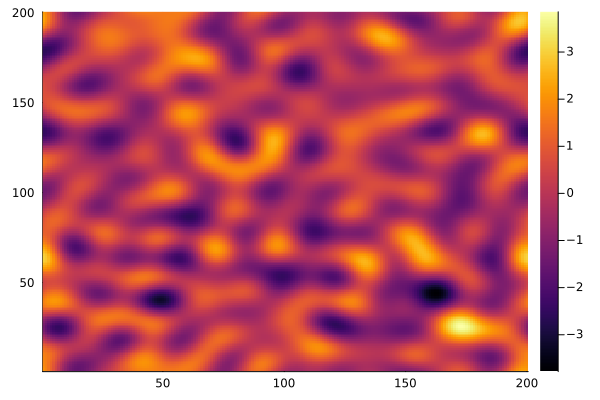

In [50]:
heatmap(res[:,:,1,1,1])

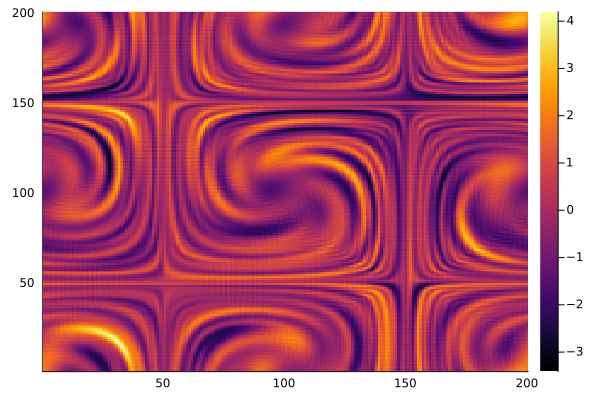

In [51]:
heatmap(res[:,:,1,1,end])